In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np

In [85]:
# Define start and end date
start_date = "1991-01-01"
end_date = "2014-12-31"

clim = 'miroc6'
x = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/x.pt', weights_only = False).to('cpu').squeeze(-1).numpy()
y = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/y.pt', weights_only = False).to('cpu').squeeze(-1).numpy()
xt = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/ep40/xt.pt', weights_only = False)

time = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-livneh/QM_ANN_layers4_degree1_quantile0.5/all/1950_1980/1991_2014/time.pt', weights_only = False)

In [86]:

x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
# Generate a daily time array following the standard Gregorian calendar
y_time = pd.date_range(start=start_date, end=end_date, freq="D")

# Convert to NumPy array for indexing and comparison
y_time_np = y_time.to_numpy()

# Find indices where observed time matches model time
matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

y = y[matched_indices,:]

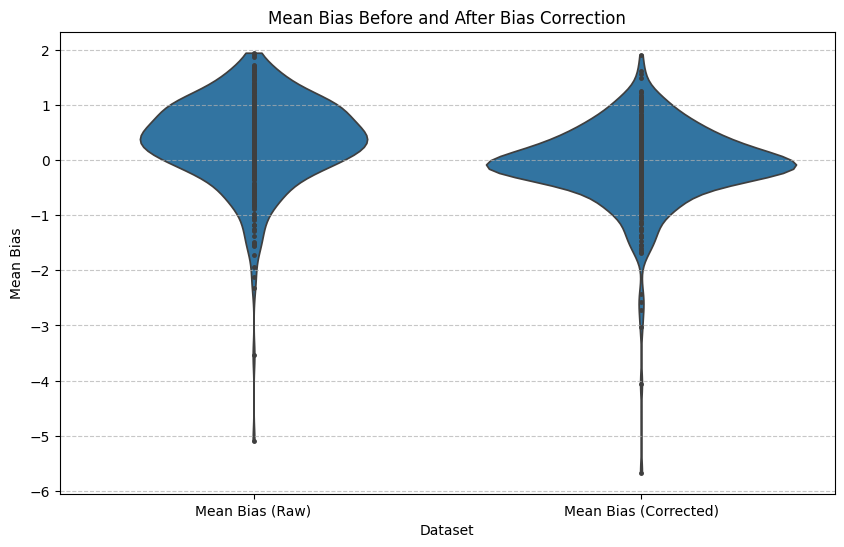

In [87]:
# Compute bias for each coordinate
bias_raw = np.mean(x - y, axis=0)  # Mean bias of raw data
bias_corrected = np.mean(xt - y, axis=0)  # Mean bias of corrected data

# Create a dataframe for visualization
df_bias = pd.DataFrame({
    "Bias Value": np.concatenate([bias_raw, bias_corrected]),
    "Type": (["Mean Bias (Raw)"] * len(bias_raw)) + (["Mean Bias (Corrected)"] * len(bias_corrected))
})

# Plot mean bias beanplot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Type", y="Bias Value", data=df_bias, inner="point", cut=0)
plt.title("Mean Bias Before and After Bias Correction")
plt.ylabel("Mean Bias")
plt.xlabel("Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

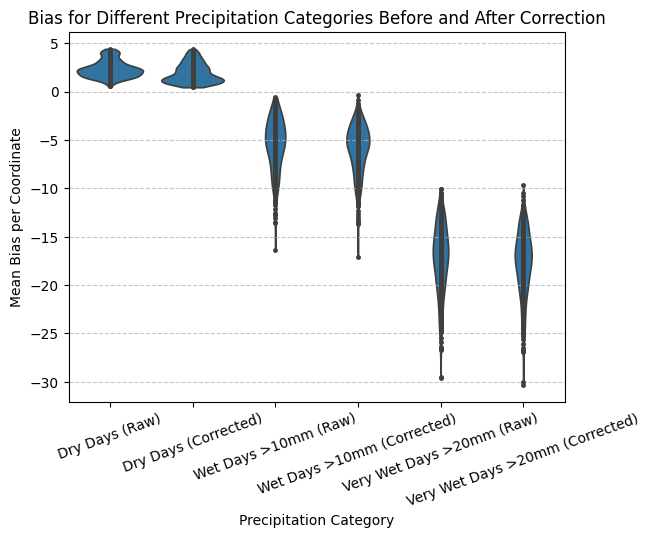

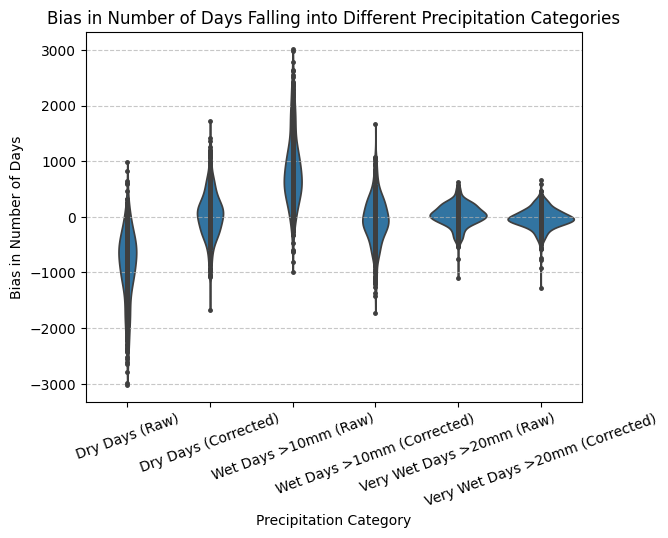

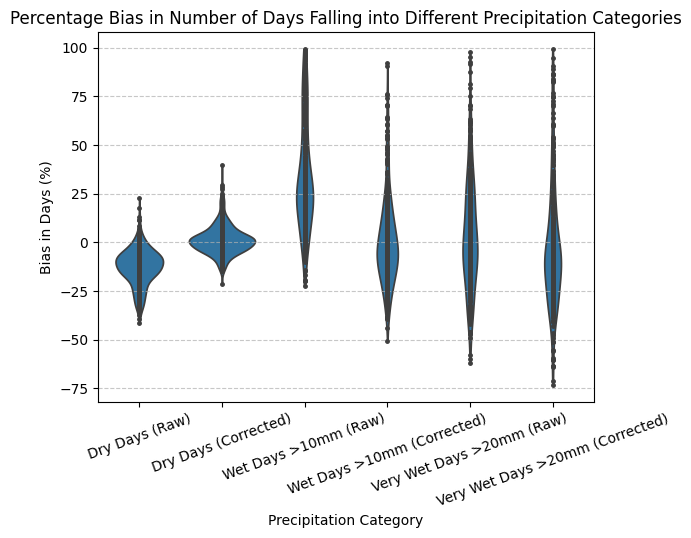

In [ ]:
# Define thresholds
dry_threshold = 1  # Dry days (<= 0 mm)
wet_threshold = 10  # Wet days (>10 mm)
very_wet_threshold = 20  # Very wet days (>20 mm)

# Function to compute mean bias per coordinate
def compute_mean_bias(mask, x, y, xt):
    mask_expanded = np.where(mask, 1, np.nan)  # Convert mask to NaN-based filter
    bias_x = np.nanmean((x - y) * mask_expanded, axis=0)  # Compute mean bias location-wise
    bias_xt = np.nanmean((xt - y) * mask_expanded, axis=0)
    return bias_x, bias_xt

# Function to compute bias in the number of days per category
def compute_day_bias(threshold, x, y, xt, comparison):
    count_x = np.sum(comparison(x, threshold), axis=0)  # Count occurrences in raw data
    count_xt = np.sum(comparison(xt, threshold), axis=0)  # Count occurrences in corrected data
    count_y = np.sum(comparison(y, threshold), axis=0)  # Reference count
    return count_x - count_y, count_xt - count_y

# Function to compute percentage bias in the number of days per category
def compute_day_bias_percentage(threshold, x, y, xt, comparison):
    count_x = np.sum(comparison(x, threshold), axis=0)
    count_xt = np.sum(comparison(xt, threshold), axis=0)
    count_y = np.sum(comparison(y, threshold), axis=0)
    percent_x = ((count_x - count_y) / (count_y + 1e-6)) * 100  # Avoid division by zero
    percent_xt = ((count_xt - count_y) / (count_y + 1e-6)) * 100
    return percent_x, percent_xt

# Compute mean bias for different precipitation categories
def get_mean_biases(x, y, xt):
    return {
        "Dry Days": compute_mean_bias(y <= dry_threshold, x, y, xt),
        "Wet Days >10mm": compute_mean_bias(y > wet_threshold, x, y, xt),
        "Very Wet Days >20mm": compute_mean_bias(y > very_wet_threshold, x, y, xt)
    }

# Compute day bias for different precipitation categories
def get_day_biases(x, y, xt):
    return {
        "Dry Days": compute_day_bias(dry_threshold, x, y, xt, np.less_equal),
        "Wet Days >10mm": compute_day_bias(wet_threshold, x, y, xt, np.greater),
        "Very Wet Days >20mm": compute_day_bias(very_wet_threshold, x, y, xt, np.greater)
    }

# Compute percentage day bias for different precipitation categories
def get_day_bias_percentages(x, y, xt):
    return {
        "Dry Days": compute_day_bias_percentage(dry_threshold, x, y, xt, np.less_equal),
        "Wet Days >10mm": compute_day_bias_percentage(wet_threshold, x, y, xt, np.greater),
        "Very Wet Days >20mm": compute_day_bias_percentage(very_wet_threshold, x, y, xt, np.greater)
    }

# Compute biases
mean_biases = get_mean_biases(x, y, xt)
day_biases = get_day_biases(x, y, xt)
day_bias_percentages = get_day_bias_percentages(x, y, xt)

# Prepare lists for dataframe
bias_values, bias_types = [], []

# Aggregate mean bias data
for label, (bias_raw, bias_corrected) in mean_biases.items():
    for bias, sublabel in [(bias_raw, "Raw"), (bias_corrected, "Corrected")]:
        if isinstance(bias, np.ndarray) and bias.size > 0:
            bias_values.extend(bias.tolist())
            bias_types.extend([f"{label} ({sublabel})"] * len(bias))

# Create dataframe
df_bias_categories = pd.DataFrame({
    "Bias Value": bias_values,
    "Type": bias_types
})

# Plot mean bias for different rainfall categories
# plt.figure(figsize=(12, 6))
sns.violinplot(x="Type", y="Bias Value", data=df_bias_categories, inner="point", cut=0)
plt.title("Bias for Different Precipitation Categories Before and After Correction")
plt.ylabel("Mean Bias per Coordinate")
plt.xlabel("Precipitation Category")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Prepare lists for day count bias dataframe
day_bias_values, day_bias_types = [], []

# Aggregate day bias data
for label, (bias_raw, bias_corrected) in day_biases.items():
    for bias, sublabel in [(bias_raw, "Raw"), (bias_corrected, "Corrected")]:
        if isinstance(bias, np.ndarray) and bias.size > 0:
            day_bias_values.extend(bias.tolist())
            day_bias_types.extend([f"{label} ({sublabel})"] * len(bias))

# Create dataframe for day count bias
df_day_bias = pd.DataFrame({
    "Bias in Days": day_bias_values,
    "Type": day_bias_types
})

# Plot bias in number of days for different categories
# plt.figure(figsize=(12, 6))
sns.violinplot(x="Type", y="Bias in Days", data=df_day_bias, inner="point", cut=0)
plt.title("Bias in Number of Days Falling into Different Precipitation Categories")
plt.ylabel("Bias in Number of Days")
plt.xlabel("Precipitation Category")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Prepare lists for day percentage bias dataframe
day_bias_percent_values, day_bias_percent_types = [], []

# Aggregate day percentage bias data
for label, (bias_raw, bias_corrected) in day_bias_percentages.items():
    for bias, sublabel in [(bias_raw, "Raw"), (bias_corrected, "Corrected")]:
        if isinstance(bias, np.ndarray) and bias.size > 0:
            day_bias_percent_values.extend(bias.tolist())
            day_bias_percent_types.extend([f"{label} ({sublabel})"] * len(bias))

# Create dataframe for day percentage bias
df_day_bias_percent = pd.DataFrame({
    "Bias in Days (%)": day_bias_percent_values,
    "Type": day_bias_percent_types
})

#manage outlier
df_day_bias_percent = df_day_bias_percent[df_day_bias_percent['Bias in Days (%)']<100]
df_day_bias_percent = df_day_bias_percent[df_day_bias_percent['Bias in Days (%)']>-100]

# Plot bias in percentage of days for different categories
# plt.figure(figsize=(12, 6))
sns.violinplot(x="Type", y="Bias in Days (%)", data=df_day_bias_percent, inner="point", cut=0)
plt.title("Percentage Bias in Number of Days Falling into Different Precipitation Categories")
plt.ylabel("Bias in Days (%)")
plt.xlabel("Precipitation Category")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [102]:
import data.valid_crd as valid_crd
cmip6_dir = '/pscratch/sd/k/kas7897/cmip6'
clim_data = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc')
valid_coords = valid_crd.valid_lat_lon(clim_data, 'pr')

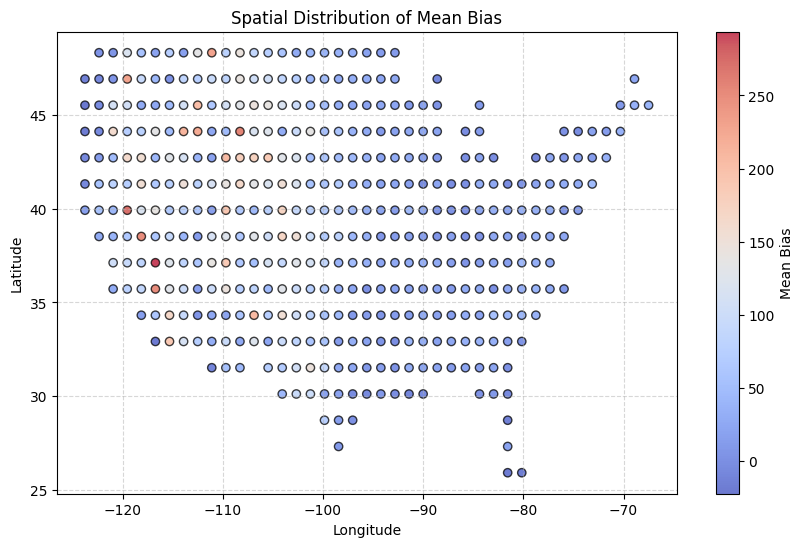

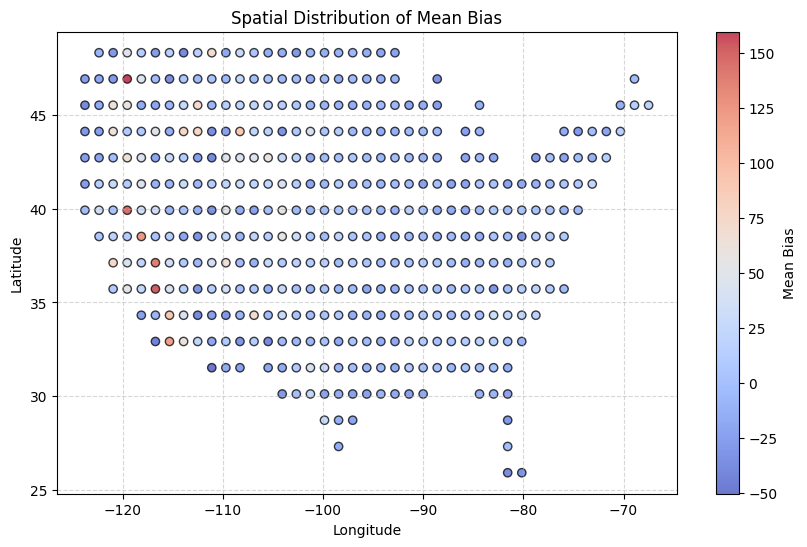

In [124]:
# Generate spatial plot
def plot_spatial_bias(valid_coords, mean_bias_values):
    lats, lons = zip(*valid_coords)  # Extract latitudes and longitudes
    
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(lons, lats, c=mean_bias_values, cmap="coolwarm", marker="o", edgecolor="k", alpha=0.75)
    plt.colorbar(sc, label="Mean Bias")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Spatial Distribution of Mean Bias")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


plot_spatial_bias(valid_coords, day_bias_percentages['Wet Days >10mm'][0])
plot_spatial_bias(valid_coords, day_bias_percentages['Wet Days >10mm'][1])

In [123]:
day_bias_percentages.keys()

dict_keys(['Dry Days', 'Wet Days >10mm', 'Very Wet Days >20mm'])